<a href="https://colab.research.google.com/github/JonathanLehner/cassini_2021_nature_discoverer/blob/main/sentinel2_processing/valais_sentinelsat_%2B_rasterio_sentinel_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Satellite imagery access and analysis in Python & Jupyter notebooks

originall from this medium article [here](https://towardsdatascience.com/satellite-imagery-access-and-analysis-in-python-jupyter-notebooks-387971ece84b)
link to their github https://github.com/shakasom/rs-python-tutorials

---




## Access, preprocess, analyse and visualize satellite images in Jupyter notebooks with Python.

The vast amount of satellite imagery collected every day across the globe is huge. In this tutorial, we will learn how to access satellite images, analyze and visualize them right in Jupyter notebooks with python. Satellite images are pixel wised data just like any other types of images you have used. In Geography and Remote sensing terminology, this is called Rasters. Raster images mainly consist of satellite images, Lidar data as well as Georeferenced maps. As we will see, rasters consist of a matrix of cells and row and each cell holds information about the location, such as elevation, temperature and vegetation.


In this tutorial, we will cover the following:
* Querry, retrieve and download satellite images directly with Python in Jupyter notebook.
* Read and Write Raster images in Python.
* Create RGB and NDVI images from Sentinel 2 Bands

### Accessing data
In this tutorial, we will use Sentinel 2 data. There are many options to access Sentinel 2 images and most of them will require you to access through website interaction whether directly via a downloading service utility or via the cloud. However, since we are using Jupyter notebook, we will access them right here using, sentinelsat a python library which makes searching, retrieving and downloading Sentinel satellite images easy. So let us start installing sentinelsat through pip.

# setup

In [1]:
%%capture
!pip install sentinelsat
!pip install rasterio
!pip install folium
!apt install gdal-bin python-gdal python3-gdal 
!apt install python3-rtree 
!pip install git+git://github.com/geopandas/geopandas.git
!pip install descartes 
!pip install contextily


In [2]:
import folium
import os
import numpy as np

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import fiona

In [3]:
!pip install -U tqdm

import zipfile
from datetime import datetime
import os
from os import listdir
from os.path import isfile, join
import pprint as pp
from natsort import natsorted
import pandas as pd
import requests
import string
import re
import time
import distutils
import distutils.core
from google.colab import data_table, files
from tqdm.auto import tqdm
%load_ext google.colab.data_table


     |████████████████████████████████| 81kB 5.8MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


## function defs

In [4]:
def fast_scandir(dirname):
    # return all subfolders in a given filepath

    subfolders = [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders # list
    
def URL_string_filter(text):
    custom_printable = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ._"

    filtered = ''.join((filter(lambda i: i in custom_printable, text)))

    return filtered 


def getFilename_fromCd(cd):
    #Get filename from content-disposition
    custom_printable = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ."

    if not cd:
        return None
    fname = re.findall('filename=(.+)', cd)
    # fname = re.findall('filename=', cd)
    if len(fname) > 0:
        output = fname[0]
    elif cd.find('/'):
        possible_fname = url.rsplit('/', 1)[1]
        output = URL_string_filter(possible_fname)
    else:
        output = None
    return output

In [5]:
# formats all notebook cells to not look ugly

from IPython.display import HTML, display
def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## create username / load

Before we are able to use sentinelsat, we need to register a username in [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home) and note down your username and password and paste them here inside the code.

```
peterszemraj@gmail.com
laminate7!
```


In [6]:
user = 'pszemraj' 
password = 'laminate7' 

api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

You are all set to use sentinelsat and download Sentinel Satellite images. In this tutorial, we will use data from Roma city, Italy. In the southern part of Roma, there is a natural reserve called Castel Porziano which we will use as a boundary to clip from the whole satellite image tile. 
I have the boundary of the natural reserve as Shapefile and we will read it with Geopandas and visualize it with Folium python library.

## download zip file

In [7]:
this_url = "https://www.dropbox.com/sh/zthidfxgxeyq4vn/AADC9QnFxaRdlN7FerMVqRSLa?dl=1" #@param {type:"string"}
folder_name = "valais_shape_file" #@param {type:"string"}

import os

try:
    print("the current directory is already: ", the_wd)
except:
    machine_dir = os.getcwd()
    the_wd = os.path.join(machine_dir, folder_name)
    os.mkdir(the_wd)
    os.chdir(the_wd)
    print("files will be stored on the local machine running at: \n", os.getcwd())


files will be stored on the local machine running at: 
 /content/valais_shape_file


In [8]:
print("starting to download and save file ")

r = requests.get(this_url, allow_redirects=True)
names = getFilename_fromCd(r.headers.get('content-disposition'))
fixed_fnames = names.split(";") # split the multiple results
this_filename = URL_string_filter(fixed_fnames[0])
this_filename = "dropboxexport" + this_filename

save_loc = join(the_wd, this_filename)

open(save_loc, 'wb').write(r.content)

print("saved zip file - ", datetime.now())

starting to download and save file 
saved zip file -  2021-06-20 11:53:58.336325


extract

In [9]:
print_dir = False #@param {type:"boolean"}
zf = zipfile.ZipFile(save_loc)
if print_dir:
    pp.pprint(zf.printdir(), indent=5, compact=True) # depending on any other subfolders, printout can be massive
zf.extractall()

print("extracted zip file - ", datetime.now())

extracted zip file -  2021-06-20 11:53:58.348484


delete the zip file itself

In [10]:
try:
    os.remove(save_loc)
    del save_loc
    print("deleted origin zip file post extraction - ", datetime.now())
except:
    print("unable to delete original zipfile - check if exists")

deleted origin zip file post extraction -  2021-06-20 11:53:58.360377


### summary

In [11]:
current_wd = os.getcwd()
print("The current working directory is: \n", current_wd)
print("\nA list of all files in working directory is:")
local_files = natsorted([f for f in listdir(current_wd) if isfile(os.path.join(current_wd, f))])
pp.pprint(local_files)

print("\nA list of all subfolders is:")
pp.pprint(fast_scandir(current_wd))

print("\n current server date & time: ", datetime.now())


The current working directory is: 
 /content/valais_shape_file

A list of all files in working directory is:
['POLYGON.dbf', 'POLYGON.prj', 'POLYGON.shp', 'POLYGON.shx']

A list of all subfolders is:
[]

 current server date & time:  2021-06-20 11:53:58.374959


## how to get the shape file - geojson

http://geojson.io/#map=2/20.0/0.0



In [12]:
nReserve = gpd.read_file('POLYGON.shp')
nReserve

,geometry
0,"POLYGON ((7.11000 46.15000, 7.10610 46.15038, ..."


In [13]:
m = folium.Map([46.066667, 7.6], zoom_start=11)

folium.GeoJson(nReserve).add_to(m)
m

With the above code, we have read natural reserve shapefile in Geopandas and called it nReserve, then later created an empty base map in Folium centred around coordinates in the area, we call this m. Finally, we can add the Geopandas data to the base map we have created to visualize the Natural Reserve boundary we are interested in. Below you can see the map.

One last step before we can search and download sentinel 2 images is to create a footprint from the nReservegeometry. Here we will use Shapely Python library since our data is in Shapefiles and read it already as Geopandas GeodataFrame. (Note that if you have Geojson data, Sentinelsat provides a handy way to convert your data into a proper format in the query).

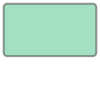

In [14]:
footprint = None
for i in nReserve['geometry']:
    footprint = i
    
footprint

Now we can run a query on the apiwe have created above. There are different ways you can construct your query here depending on your use case. In this example, we will create a query for Sentinel 2 images Level 2A with cloud coverage between 0 and 10 that fall or intersect with the footprint (Area of study). For the time period, we are interested in Sentinel Level 2A satellite images taken between '20190601' and '20190626' (For reference on valid search queries please refer to[ scihub](https://scihub.copernicus.eu/twiki/do/view/SciHubUserGuide/FullTextSearch?redirectedfrom=SciHubUserGuide.3FullTextSearch)).

In [15]:
products = api.query(footprint,
                     date = ('20210101', '20210615'),
                     platformname = 'Sentinel-2',
                    #  processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,15))

len(products)

16

We get a dictionary of all products available in this period with the query specification. In this case, we receive only 6 images taken but you can tweak the query for your use case example expanding the time period or increasing the cloud coverage percentage.  


From here we can create a GeodataFrame or Dataframe from the product dictionary and sort them according to cloud coverage percentage.

In [16]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
# products_gdf_sorted = products_gdf[products_gdf['ondemand'] == True]

data_table.DataTable(products_gdf_sorted, 
                     include_index=True, num_rows_per_page=15)

,title,link,link_alternative,link_icon,summary,ondemand,generationdate,beginposition,endposition,ingestiondate,orbitnumber,relativeorbitnumber,illuminationazimuthangle,illuminationzenithangle,vegetationpercentage,notvegetatedpercentage,waterpercentage,unclassifiedpercentage,mediumprobacloudspercentage,highprobacloudspercentage,snowicepercentage,cloudcoverpercentage,level1cpdiidentifier,format,processingbaseline,platformname,filename,instrumentname,instrumentshortname,size,s2datatakeid,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,datastripidentifier,granuleidentifier,identifier,uuid,datatakesensingstart,sensoroperationalmode,tileid,hv_order_tileid,geometry
5541061b-484e-477d-b424-a3a088232bde,S2B_MSIL1C_20210401T101559_N0300_R065_T32TLS_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-04-01T10:15:59.024Z, Instrument: MS...",false,2021-04-01 13:22:44,2021-04-01 10:15:59.024,2021-04-01 10:15:59.024,2021-04-01 15:49:00.426,21255,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,S2B_OPER_MSI_L1C_TL_VGS4_20210401T132244_A0212...,SAFE,03.00,Sentinel-2,S2B_MSIL1C_20210401T101559_N0300_R065_T32TLS_2...,Multi-Spectral Instrument,MSI,169.38 MB,GS2B_20210401T101559_021255_N03.00,S2MSI1C,2017-013A,DESCENDING,Sentinel-2B,Level-1C,S2B_OPER_MSI_L1C_DS_VGS4_20210401T132244_S2021...,S2B_OPER_MSI_L1C_TL_VGS4_20210401T132244_A0212...,S2B_MSIL1C_20210401T101559_N0300_R065_T32TLS_2...,5541061b-484e-477d-b424-a3a088232bde,2021-04-01 10:15:59.024,INS-NOBS,32TLS,TS32L,"MULTIPOLYGON (((7.43619 45.95307, 7.83596 45.9..."
c9161087-a1dd-41c8-9323-5310dee0811d,S2B_MSIL1C_20210404T102559_N0300_R108_T32TLS_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-04-04T10:25:59.024Z, Instrument: MS...",false,2021-04-04 12:37:05,2021-04-04 10:25:59.024,2021-04-04 10:25:59.024,2021-04-04 15:28:29.671,21298,108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020100,S2B_OPER_MSI_L1C_TL_VGS2_20210404T123705_A0212...,SAFE,03.00,Sentinel-2,S2B_MSIL1C_20210404T102559_N0300_R108_T32TLS_2...,Multi-Spectral Instrument,MSI,869.62 MB,GS2B_20210404T102559_021298_N03.00,S2MSI1C,2017-013A,DESCENDING,Sentinel-2B,Level-1C,S2B_OPER_MSI_L1C_DS_VGS2_20210404T123705_S2021...,S2B_OPER_MSI_L1C_TL_VGS2_20210404T123705_A0212...,S2B_MSIL1C_20210404T102559_N0300_R108_T32TLS_2...,c9161087-a1dd-41c8-9323-5310dee0811d,2021-04-04 10:25:59.024,INS-NOBS,32TLS,TS32L,"MULTIPOLYGON (((6.42003 45.93642, 7.83596 45.9..."
1fd8ed4e-87e0-4266-befb-ae340773d0ee,S2A_MSIL1C_20210330T103021_N0300_R108_T32TLS_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-03-30T10:30:21.024Z, Instrument: MS...",false,2021-03-30 14:23:39,2021-03-30 10:30:21.024,2021-03-30 10:30:21.024,2021-03-30 17:03:49.036,30135,108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.201100,S2A_OPER_MSI_L1C_TL_VGS2_20210330T142339_A0301...,SAFE,03.00,Sentinel-2,S2A_MSIL1C_20210330T103021_N0300_R108_T32TLS_2...,Multi-Spectral Instrument,MSI,874.74 MB,GS2A_20210330T103021_030135_N03.00,S2MSI1C,2015-028A,DESCENDING,Sentinel-2A,Level-1C,S2A_OPER_MSI_L1C_DS_VGS2_20210330T142339_S2021...,S2A_OPER_MSI_L1C_TL_VGS2_20210330T142339_A0301...,S2A_MSIL1C_20210330T103021_N0300_R108_T32TLS_2...,1fd8ed4e-87e0-4266-befb-ae340773d0ee,2021-03-30 10:30:21.024,INS-NOBS,32TLS,TS32L,"MULTIPOLYGON (((6.42003 45.93642, 7.83596 45.9..."
e1fc26ff-dd66-4460-a834-1e7b74c275a7,S2B_MSIL1C_20210223T102929_N0209_R108_T32TLS_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-02-23T10:29:29.024Z, Instrument: MS...",false,2021-02-23 12:43:28,2021-02-23 10:29:29.024,2021-02-23 10:29:29.024,2021-02-23 16

Let us say we are interested in the first satellite image since this has the least cloud coverage of all available images. we can simply call download and provide the product name (Note that you can download all images at once with api.download_all() function).

In [17]:
download_new_tiff = False #@param {type:"boolean"}

if download_new_tiff:
    products_gdf_sorted.reset_index(drop=False, inplace=True)
    top_img = str(products_gdf_sorted.loc[0,"index"])
    api.download(top_img)

This will take a while (Sentinel 2 Satellite image tiles are about 1 GB). Once the download is finished, we can simply unzip it. In the next section, we will use the downloaded satellite images to process, analyze and visualize them.

## Exploring Satellite Imagery with Rasterio
Once we unzip the downloaded folder, we get many subfolders and it is sometimes hard to navigate through these folders. Sentinel-2 data is multispectral with 13 bands in the visible, near infrared and shortwave infrared spectrum. These bands come in a different spatial resolution ranging from 10 m to 60 m, thus images can be categorized as high-medium resolution. While there are other higher resolution satellites available(1m to 0.5 cm), Sentinel-2 data is free and has a high revisit time (5 days) which makes it an excellent option to study environmental challenges.

# Bands Analysis

The true colour of satellite images is often displayed in a combination of red, green and blue band. Let us first read the data with Rasterio and create an RGB image 

## start with a .tif zip file

In [18]:
sentinel_tif_imgs = "https://www.dropbox.com/s/nlswgxc6ulbpsbt/vs_aoi_s2_l2a_10m_swiss_202001151039.tif?dl=1" #@param {type:"string"}
new_folder = "existing_valais_imgs"

if not os.path.isdir(join(the_wd, new_folder)):
    os.mkdir(join(the_wd, new_folder))
    print("created folder")

path_to_new_loc = join(the_wd, new_folder)

created folder


In [19]:
r = requests.get(sentinel_tif_imgs, allow_redirects=True)

names = getFilename_fromCd(r.headers.get('content-disposition'))
fixed_fnames = names.split(";") # split the multiple results
this_filename = URL_string_filter(fixed_fnames[0])
# this_filename = "dropboxexport" + this_filename

save_loc_2 = join(path_to_new_loc, this_filename)

open(save_loc_2, 'wb').write(r.content)

126039303

In [20]:
if save_loc_2.endswith(".zip"):
    zf2 = zipfile.ZipFile(save_loc_2)
    zf2.extractall()
else:
    print("filename is not zip, it is: \n", save_loc_2)

filename is not zip, it is: 
 /content/valais_shape_file/existing_valais_imgs/vs_aoi_s2_l2a_10m_swiss_202001151039.tif


In [21]:
print("\nA list of all files in working directory is:")
local_files = natsorted([f for f in listdir(path_to_new_loc) if isfile(os.path.join(path_to_new_loc, f))])
pp.pprint(local_files)


A list of all files in working directory is:
['vs_aoi_s2_l2a_10m_swiss_202001151039.tif']


## load and analyze file

taken from [here](https://medium.com/analytics-vidhya/satellite-imagery-analysis-with-python-3f8ccf8a7c32) mostly

In [22]:
chosen_fname = "vs_aoi_s2_l2a_10m_swiss_202001151039.tif"
chosen_input_path = join(the_wd, new_folder, chosen_fname)

In [23]:
# Open file wwith Rasterio

sat_data  = rio.open(chosen_input_path)
print(sat_data.crs)
print(sat_data.transform)

width_in_projected_units = sat_data.bounds.right - sat_data.bounds.left
height_in_projected_units = sat_data.bounds.top - sat_data.bounds.bottom

print("Width: {}, Height: {}".format(width_in_projected_units, height_in_projected_units))

EPSG:4326
| 0.00, 0.00, 7.11|
| 0.00,-0.00, 46.43|
| 0.00, 0.00, 1.00|
Width: 0.4885125978347675, Height: 0.2590786411674344


### pixel coords in image

In [24]:
# Upper left pixel
row_min = 0
col_min = 0

# Lower right pixel.  Rows and columns are zero indexing.
row_max = sat_data.height - 1
col_max = sat_data.width - 1

# Transform coordinates with the dataset's affine transformation.
topleft = sat_data.transform * (row_min, col_min)
botright = sat_data.transform * (row_max, col_max)

print("Top left corner coordinates: {}".format(topleft))
print("Bottom right corner coordinates: {}".format(botright))

Top left corner coordinates: (7.108022991187527, 46.428005592636254)
Bottom right corner coordinates: (7.366988051188287, 45.93960657596814)


In [25]:
# bands info
print(sat_data.count)

# sequence of band indexes
print(sat_data.indexes)

13
(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)


In [26]:
from rasterio import features

with rasterio.open(chosen_input_path) as src:
    das_polygon = src.read()

shapes = features.shapes(das_polygon)
pp.pprint(next(shapes))


({'coordinates': [[(0.0, 0.0), (0.0, 2.0), (3.0, 2.0), (3.0, 0.0), (0.0, 0.0)]],
  'type': 'Polygon'},
 11421.0)


info on bands

In [27]:
import pprint as pp
bands_info = {i: dtype for i, dtype in zip(sat_data.indexes, sat_data.dtypes)}

pp.pprint(bands_info)

{1: 'int16',
 2: 'int16',
 3: 'int16',
 4: 'int16',
 5: 'int16',
 6: 'int16',
 7: 'int16',
 8: 'int16',
 9: 'int16',
 10: 'int16',
 11: 'int16',
 12: 'int16',
 13: 'int16'}


plot

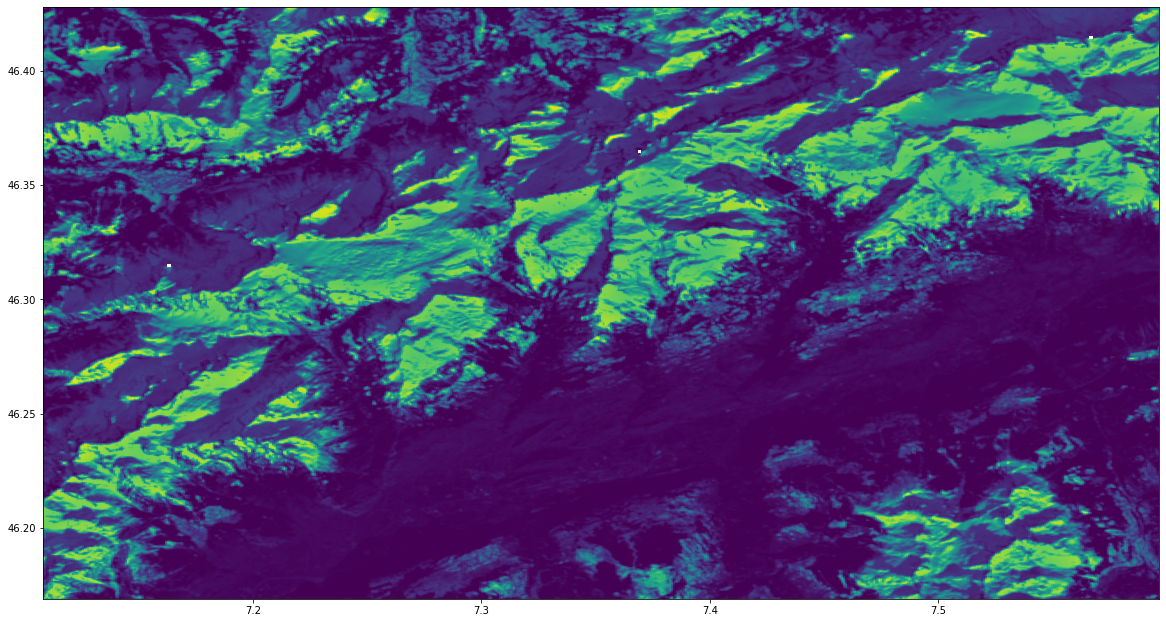

In [28]:
fig, ax = plt.subplots(1, figsize=(20, 20))
show(sat_data, ax=ax)
plt.show()

## show fancier valais image just downloaded

In [30]:
dl_name = "S2B_MSIL1C_20210401T101559_N0300_R065_T32TLS_20210401T132244.zip"
dl_path = ""


if dl_path.endswith(".zip"):
    zf2 = zipfile.ZipFile(dl_path)
    # zf2.printdir()
    zf2.extractall()
else:
    print("filename is not zip, it is: \n", dl_path)

img_folder = join(os.getcwd(), dl_name.split(".")[0])
img_folder = "/content/valais_shape_file/S2B_MSIL1C_20210401T101559_N0300_R065_T32TLS_20210401T132244.SAFE"
print("\nA list of all files in the new folder directory is:")
local_files = natsorted([f for f in listdir(img_folder) if isfile(os.path.join(img_folder, f))])
pp.pprint(local_files)

print("\nthere ar ealso the subfolders: \n")
pp.pprint(fast_scandir(img_folder))


filename is not zip, it is: 
 

A list of all files in the new folder directory is:


FileNotFoundError: ignored

In [ ]:
# fig, ax = plt.subplots(1, figsize=(20, 20))
# show(sat_data, ax=ax)
# plt.show()

### Mask Satellite images

One important preprocessing task to clip or mask an area of study. Since this RGB image is large and huge you save both computing power and time to clip and use only the area of interest. We will clip the Natural reserve area from the RGB image.

In [ ]:
# #src = rio.open(r"RGB.tiff")
# nReserve_proj = nReserve.to_crs({'init': 'epsg:32633'})

# with rio.open("RGB.tiff") as src:
#     out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
#     out_meta = src.meta.copy()
#     out_meta.update({"driver": "GTiff",
#                  "height": out_image.shape[1],
#                  "width": out_image.shape[2],
#                  "transform": out_transform})
    
# with rasterio.open("RGB_masked.tif", "w", **out_meta) as dest:
#     dest.write(out_image)

Here, we first reproject our Natural reserve with the same projection as the RGB image. Next, we open the RGB image, get the metadata and mask with the projected boundary.

In [ ]:
# msk = rio.open(r"RGB_masked.tif")
# fig, ax = plt.subplots(1, figsize=(18, 18))
# show(msk.read([1,2,3]))
# plt.show

### Create NDVI 
Calculating Normalized Difference Vegetation Index (NDVI) is an important indicator to assess the presence/absence of green vegetation from the satellite images. To calculate the NDVI, you need Red band and Near-Infrared Band (NIR). Different satellite images assign different numbers for this band. Sentinel Images have red in 4th band and NIR in the 8th band. The formula for NDVI calculation is:
nir - red /(nir + red).

To carry out this in Rasterio we need first to read the 4th and 8th bands as arrays. We also need to make sure that the arrays are floats.

In [ ]:
b4red = sat_data.read(4)
b8nir = sat_data.read(8)


In [ ]:

ndvi = (b8nir.astype(float)-b4red.astype(float))/(b8nir+b4red)

In [ ]:
meta = sat_data.meta

meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

fig, ax = plt.subplots(1, figsize=(20, 20))
show(ndvi, ax=ax)
plt.show()

# with rasterio.open('[NDVI analysis]' + chosen_fname, 'w', **meta) as dst:
#     dst.write(ndvi.astype(rasterio.float))

# continued on other tutorial

- [Python for Geosciences: Satellite Image Analysis (step by step)](https://medium.com/analytics-vidhya/python-for-geosciences-satellite-image-analysis-step-by-step-6d49b1ad567)


## read iamges fn

In [ ]:
from pathlib import Path

def load_landsat_image_dir(img_folder, bands):
    # ONLY USEFUL IF BANDS ARE IN DIFFERENT FILE
    image = {}
    path = Path(img_folder)
    for band in bands:
        # considering the landsat images end with *_SR_B#.TIF, we will use it to locate the correct file
        file = next(path.glob(f'*_SR_{band}.tif'))
        print(f'Opening file {file}')
        ds = rasterio.open(file)
        image.update({band: ds.read(1)})

    return image

def load_landsat_image_single(imgpath):
    # ONLY USEFUL IF BANDS ARE IN DIFFERENT FILE
    image = {}
    datboi  = rio.open(imgpath)
    bands = datboi.indexes
    for band in bands:
        # considering the landsat images end with *_SR_B#.TIF, we will use it to locate the correct file
        this_label = "B" + str(band)
        image.update({this_label: datboi.read(band)})

    return image

## create nice color image

From Landsat documentation we know that B4=Red, B3=Green and B2=Blue



In [ ]:
download_pic = True #@param {type:"boolean"}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

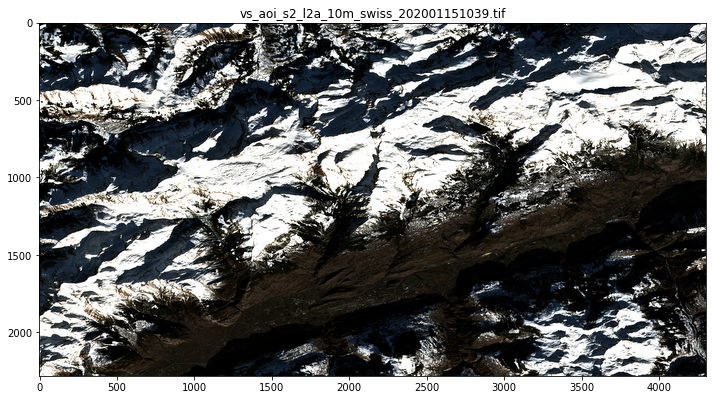

In [39]:
import matplotlib
from google.colab import files

img = load_landsat_image_single(chosen_input_path)

# stack the layers to create a cube
rgb = np.stack([img['B4'], img['B3'], img['B2']], axis=-1)

# normalize the values
rgb = rgb/rgb.max() * 2

# display the image with a slightly increased figure size
plt.figure(figsize=(10,10), tight_layout=True)
plt.imshow(rgb, norm=matplotlib.colors.Normalize(), interpolation ="lanczos")

if download_pic:
    outname = "prty RGB img" + os.path.basename(chosen_input_path).replace(".", "") + ".png"
    plt.savefig(outname, dpi=200, facecolor='w', edgecolor='w',
            transparent=True, bbox_inches="tight")
    plt.title(os.path.basename(chosen_input_path))
    files.download(outname)

other topics such as *Spectral signature of water pixels* in [tutorial](https://medium.com/analytics-vidhya/python-for-geosciences-spectral-analysis-step-by-step-e400441a57e7)

# How To Compute Satellite Image Statistics And use It In Pandas

- a [link](https://towardsdatascience.com/how-to-compute-satellite-image-statistics-and-use-it-in-pandas-81864a489144) to this medium article here


In [40]:
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt

```
# whe
buildings = gpd.read_file(“/content/Data/shapefiles/osm_buildings.shp”)
buildings = buildings[[“osm_id”,”building”, “geometry”]]
buildings.head()
```

where buildings is a shape file. you can plot these on top of the sentinel images:

```
fig, ax = plt.subplots(figsize=(12, 10))
show(b4, ax=ax)
buildings.plot(ax=ax, color=”white”, alpha=.50)
plt.show();
```


In [41]:
# add 

the rest of this tutorial can be found [here](https://github.com/shakasom/zonalstatistics)

# Python for Geosciences: Raster Merging, Clipping and Reprojection with Rasterio
Learn how to perform raster reprojection, clipping and merging using the rasterio package for Python

- [link](https://medium.com/analytics-vidhya/python-for-geosciences-raster-merging-clipping-and-reprojection-with-rasterio-9f05f012b88a) to the article

# Shape Files - Generate


[pyshape](https://pypi.org/project/pyshp/) to create and edit shape files

In [42]:
%%capture 

!pip install pyshp

import shapefile

In [43]:
import pandas as pd
csv_url_db = "https://www.dropbox.com/s/xviajtrd68x8lyi/bouldering%20and%20climbing%20areas%20-%20valais%20-%20thecrag.csv?dl=1"
bouldering_locs = pd.read_csv(csv_url_db).convert_dtypes()

bouldering_locs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Type       28 non-null     string 
 1   Link       28 non-null     string 
 2   Latitude   28 non-null     float64
 3   Longitude  28 non-null     float64
dtypes: float64(2), string(2)
memory usage: 1.0 KB


In [44]:

current_dir = os.getcwd()
shp_name = "rock_climbing_valais_locs"
print("current working directory is {}".format(current_dir))
w = shapefile.Writer(join(current_dir,shp_name), shapeType=shapefile.POINT)
# w.field('name', 'C')
# w.field("purpose", "mark valais bouldering and climbing areas")
# w.field("types", "boulder climb and mountaineer")
w.field("type", "C")
w.field("osm_id", "C")
w.field("name", "C")
count = 0 

bouldering_locs["Longitude"] = bouldering_locs["Longitude"].apply(float)
for index, row in bouldering_locs.iterrows():
    count += 1
    this_lat = row["Latitude"]
    this_lon = row["Longitude"]
    w.point(this_lat, this_lon)

    w.record('point', str(count + 42069), row["Type "] + str(count))

w.close()

from natsort import natsorted
# iterate through and grab files:

files_to_munch = natsorted([f for f in listdir(current_dir) if isfile(os.path.join(current_dir, f))])
print("\n current files in {}".format(current_dir))
pp.pprint(files_to_munch)

current working directory is /content/valais_shape_file

 current files in /content/valais_shape_file
['POLYGON.dbf',
 'POLYGON.prj',
 'POLYGON.shp',
 'POLYGON.shx',
 'prty RGB imgvs_aoi_s2_l2a_10m_swiss_202001151039tif.png',
 'rock_climbing_valais_locs.dbf',
 'rock_climbing_valais_locs.shp',
 'rock_climbing_valais_locs.shx']


In [45]:
for output in files_to_munch:
    if shp_name in output:
        files.download(join(current_dir, output))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# shape files - plot over

In [59]:
def extract_zip_URL(URL, folder_path):
    print("\n\nstarting to download and save file ")

    r = requests.get(URL, allow_redirects=True)
    names = getFilename_fromCd(r.headers.get('content-disposition'))
    fixed_fnames = names.split(";") # split the multiple results
    this_filename = URL_string_filter(fixed_fnames[0])
    this_filename = "dropboxexport" + this_filename

    save_loc = join(folder_path, this_filename)

    open(save_loc, 'wb').write(r.content)

    print("saved zip file - ", datetime.now())

    zf = zipfile.ZipFile(save_loc)
    zf.extractall(path=folder_path)

    print("extracted zip file - ", datetime.now())

    try:
        os.remove(save_loc)
        del save_loc
        print("deleted origin zip file post extraction - ", datetime.now())
    except:
        print("unable to delete original zipfile - check if exists")

    local_files = natsorted([f for f in listdir(folder_path) if isfile(os.path.join(folder_path, f))])
    if len(local_files) < 10:
        pp.pprint(local_files)
    else:
        print("there are {} files in folder: {}".format(len(local_files), current_wd))

    print("\nA list of all subfolders is:")
    pp.pprint(fast_scandir(folder_path))




## download zips and unpack

In [60]:
use_bouldering = True #@param {type:"boolean"}
use_OSM = True #@param {type:"boolean"}
directory_shapes = join(current_dir, "shape_files")

if not os.path.isdir(directory_shapes):
    os.mkdir(directory_shapes)
    print("created folder")
    # make a place to store outputs if one does not exist

bouldering_shapes_URL = "https://www.dropbox.com/sh/6woym4j24ex5zhz/AADzos2OU5XDpWlRVCycLRqca?dl=1"
points_of_interest_URL = "https://www.dropbox.com/sh/5xorzb90x2dkyiw/AAANC3eiuWjolSeYoGowAV8na?dl=1"

if use_bouldering:
    extract_zip_URL(bouldering_shapes_URL, directory_shapes)
if use_OSM:
    extract_zip_URL(points_of_interest_URL, directory_shapes)



starting to download and save file 
saved zip file -  2021-06-20 12:10:37.612480
extracted zip file -  2021-06-20 12:10:37.614418
deleted origin zip file post extraction -  2021-06-20 12:10:37.615032
['rock_climbing_valais_locs.dbf',
 'rock_climbing_valais_locs.shp',
 'rock_climbing_valais_locs.shx']

A list of all subfolders is:
[]


starting to download and save file 
saved zip file -  2021-06-20 12:10:44.162107
extracted zip file -  2021-06-20 12:10:44.334138
deleted origin zip file post extraction -  2021-06-20 12:10:44.334620
there are 26 files in folder: /content/valais_shape_file

A list of all subfolders is:
['/content/valais_shape_file/shape_files/valais_exp_1_query.txt',
 '/content/valais_shape_file/shape_files/CASSINI_key_01_shp']


In [61]:
approved_shp_files = []

# r=root, d=directories, f = files
for r, d, f in os.walk(directory_shapes):
    for prefile in f:
        if prefile.endswith(".shp") or prefile.endswith(".shx"):
            fullpath = os.path.join(r, prefile)
            approved_shp_files.append(fullpath)

approved_shp_files = natsorted(approved_shp_files)

if len(approved_shp_files) < 10:
    pp.pprint(approved_shp_files)
else:
    pp.pprint(approved_shp_files[:10])
    print("\n\n and many more")


['/content/valais_shape_file/shape_files/CASSINI_key_01_planet_osm_line_lines.shp',
 '/content/valais_shape_file/shape_files/CASSINI_key_01_planet_osm_line_lines.shx',
 '/content/valais_shape_file/shape_files/CASSINI_key_01_planet_osm_point_points.shp',
 '/content/valais_shape_file/shape_files/CASSINI_key_01_planet_osm_point_points.shx',
 '/content/valais_shape_file/shape_files/CASSINI_key_01_planet_osm_polygon_polygons.shp',
 '/content/valais_shape_file/shape_files/CASSINI_key_01_planet_osm_polygon_polygons.shx',
 '/content/valais_shape_file/shape_files/CASSINI_key_01_shp/CASSINI_key_01_planet_osm_line_lines.shp',
 '/content/valais_shape_file/shape_files/CASSINI_key_01_shp/CASSINI_key_01_planet_osm_line_lines.shx',
 '/content/valais_shape_file/shape_files/CASSINI_key_01_shp/CASSINI_key_01_planet_osm_point_points.shp',
 '/content/valais_shape_file/shape_files/CASSINI_key_01_shp/CASSINI_key_01_planet_osm_point_points.shx']


 and many more


### test df

In [62]:

# test shapes
point_of_interest = gpd.read_file(approved_shp_files[0])

colnames = list(point_of_interest.columns)
if "name" not in colnames:
    spot_rep = colnames.index("natural")
    colnames[spot_rep] = "name"
point_of_interest.columns = colnames
point_of_interest = point_of_interest[["osm_id","name", "geometry"]]
point_of_interest.head()

,osm_id,name,geometry
0,116565205.0,cliff,"LINESTRING (7.20273 46.34979, 7.20200 46.34815..."
1,116565206.0,cliff,"LINESTRING (7.20130 46.34685, 7.20045 46.34658)"
2,223110751.0,cliff,"LINESTRING (7.60190 46.42197, 7.60400 46.42257..."
3,223110752.0,cliff,"LINESTRING (7.60565 46.42003, 7.60816 46.42073..."
4,228127386.0,cliff,"LINESTRING (7.12690 46.27615, 7.12679 46.27604..."


In [63]:
#construct master df
df_storage = []
verbose=False
for shp_file in tqdm(approved_shp_files):

    try:
        this_PoI = gpd.read_file(join(directory_shapes,shp_file))

        if verbose: print("this df contains {} rows".format(len(this_PoI)))
        colnames = list(this_PoI.columns)

        if "name" not in colnames:
            spot_rep = colnames.index("natural")
            colnames[spot_rep] = "name"
            this_PoI.columns = colnames

        
        this_PoI = this_PoI[["osm_id","name", "geometry"]]
        this_PoI = this_PoI[this_PoI["name"] != "forest"]
        this_PoI = this_PoI[this_PoI["name"] != "grassland"]

        df_storage.append(this_PoI)
    except:
        print("WARNING - excluding {} from the data as unable to read".format(shp_file))


len(df_storage)


14

## plot

### just the points of interest

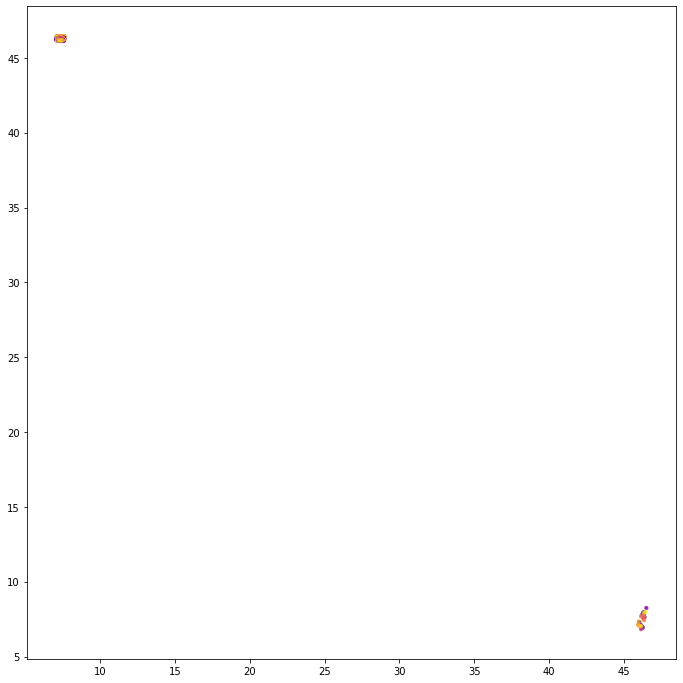

In [64]:
# normalize the values
plt.close("all")
# display the image with a slightly increased figure size
fig, ax = plt.subplots(figsize=(12, 12), clear=True)


for df in tqdm(df_storage, total=len(df_storage)):
    this_df = df.copy()
    this_df.plot(ax=ax, cmap="plasma", markersize=5,linewidth=2,
                 alpha=0.5)
plt.show()

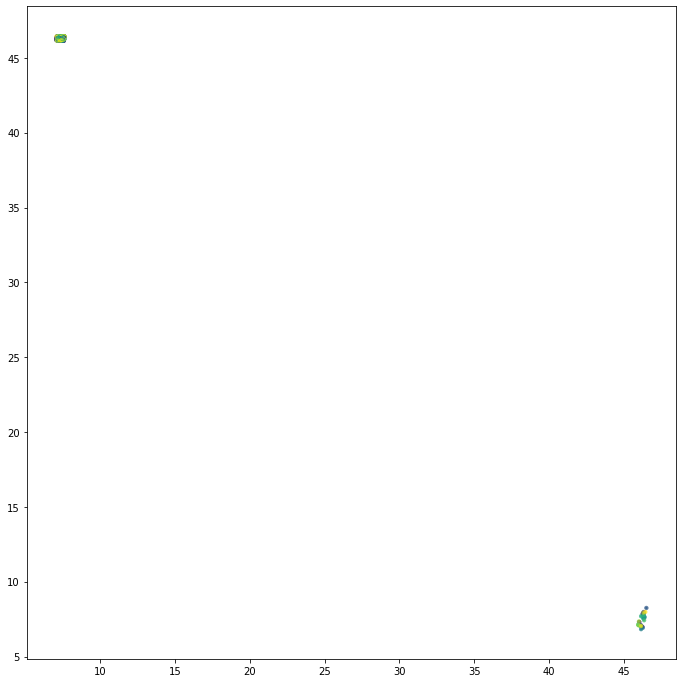

In [65]:
# method 1

import matplotlib
from google.colab import files

img2 = rasterio.open(chosen_input_path)
# stack the layers to create a cube

# normalize the values
plt.close("all")
# display the image with a slightly increased figure size
fig, ax = plt.subplots(figsize=(12, 12), clear=True)

show(img2, ax=ax)

for df in tqdm(df_storage, total=len(df_storage)):
    this_df = df.copy()
    this_df.plot(ax=ax, cmap="viridis", markersize=5,linewidth=2,
                 alpha=0.5)
plt.show()


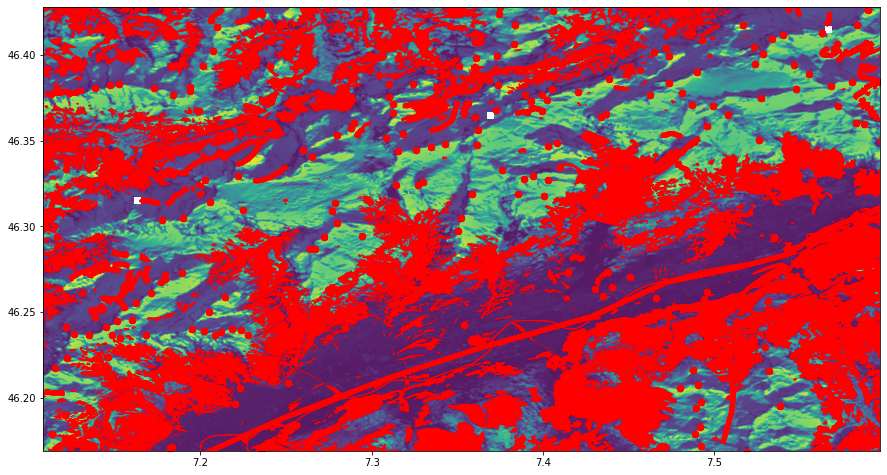

/content/valais_shape_file


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [69]:
download_full_graph = True #@param {type:"boolean"}
# option 2
import geopandas
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot
img2 = rasterio.open(chosen_input_path)


fig, ax = plt.subplots(figsize=(15, 15))
plt.axes(ax)

for df in tqdm(df_storage, total=len(df_storage)):
    this_df = df.copy()

    this_df.plot(ax=ax, color="red",markersize=5,linewidth=5)

rasterio.plot.show(img2, ax=ax, norm=matplotlib.colors.Normalize(),
                   interpolation ="spline36", alpha=0.9,
                   transform=img2.transform)

plt.show()

if download_full_graph:
    print(os.getcwd())
    outname = "[PNG + points of interest]" + os.path.basename(chosen_input_path).replace(".","") + ".png"
    plt.savefig(outname, dpi=300, bbox_inches="tight")
    files.download(outname)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


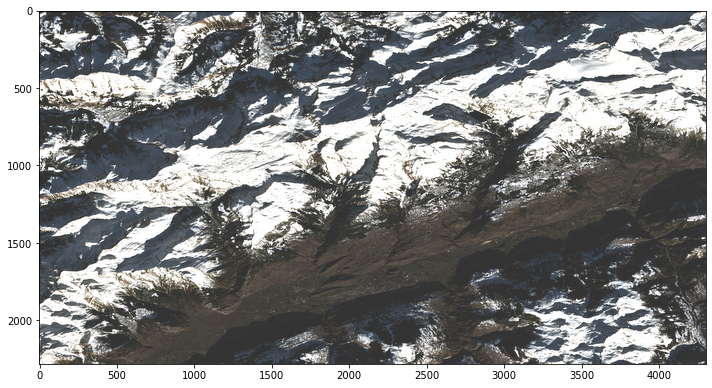

In [67]:
import matplotlib
from google.colab import files

img = load_landsat_image_single(chosen_input_path)
img2 = rasterio.open(chosen_input_path)
# stack the layers to create a cube
rgb = np.stack([img['B4'], img['B3'], img['B2']], axis=-1)

# normalize the values
rgb = rgb/rgb.max() * 2
plt.close("all")
# display the image with a slightly increased figure size
# fig, ax = plt.subplots(figsize=(12, 10), clear=True)
plt.figure(figsize=(10,10), tight_layout=True, clear=True)
plt.imshow(rgb, norm=matplotlib.colors.Normalize(),
           interpolation ="lanczos",alpha=0.8, zorder=1)

for df in tqdm(df_storage, total=len(df_storage)):
    this_df = df.copy()

    this_df.plot(ax=ax, color="red", markersize=2,linewidth=2,
            legend=True, cax=ax, zorder=10)
    

plt.show()